In [3]:
import xml.etree.ElementTree as ET
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: loading dataset

In [4]:
annotations_dir = '../data/annotations/'    
images_dir = '../data/images/'

label_lst = []
img_lst = []
img_filename = []

In [5]:
for filename in os.listdir(annotations_dir):
    dir_xml = os.path.join(annotations_dir, filename)
    tree = ET.parse(dir_xml)
    root = tree.getroot()
    
    img_name  = root.find('filename').text
    dir_img = os.path.join(images_dir, img_name)
    img = cv2.imread(dir_img)
    
    for obj in root.findall('object'):
        class_name = obj.find('name').text  
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        
        img_crop = img[ymin:ymax, xmin:xmax]

        img_lst.append(img_crop)
        label_lst.append(class_name)
    img_filename.append(img_name)
    

In [6]:
print(list(set(label_lst)))
print(len(label_lst))

['stop', 'speedlimit', 'trafficlight', 'crosswalk']
1244


speedlimit
road685.png
(84, 84, 3)


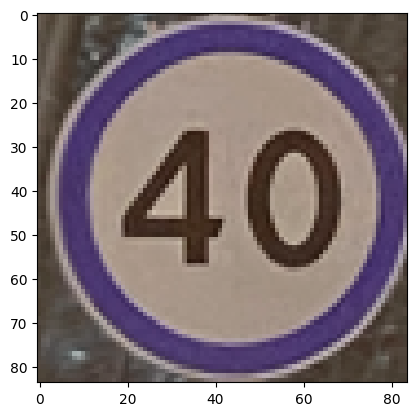

In [7]:
img_show = np.array(img_lst[0])
print(label_lst[0])
print(img_filename[0])
print(img_show.shape)
img_show = plt.imshow(img_show)

# Step 2: Preprocess image

In [11]:
#Using HoG Histogram of Oriented Gradients
# Need all sample must same size
def preprocess_image(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)
    
    resize_img = resize(img, 
                        output_shape = (32,32), 
                        anti_aliasing=True
                        )
    
    hog_feature = feature.hog(resize_img, orientations = 9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2', feature_vector=True)
    return hog_feature



In [12]:
img_features_lst = []
for img in img_lst:
    hog_feature = preprocess_image(img)
    img_features_lst.append(hog_feature)
img_features = np.array(img_features_lst)
print('x_shappe: ')
print(img_features.shape)

x_shappe: 
(1244, 324)


# Step 3: Encode label

In [13]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)
label_encoder.classes_


array(['crosswalk', 'speedlimit', 'stop', 'trafficlight'], dtype='<U12')

In [14]:
encoded_labels

array([1, 2, 1, ..., 1, 1, 1])

# Step 4: Create train, val set

In [15]:
random_state = 0
test_size = 0.3
is_shuffle = True

x_train, x_val, y_train, y_val = train_test_split(
    img_features, encoded_labels, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)

In [16]:
print(x_train.shape)

(870, 324)


# Step 5: Normalization

In [17]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [18]:
x_train 

array([[ 1.7880123 ,  0.77809006, -0.10042363, ..., -0.5747264 ,
        -0.58274007,  0.04572059],
       [ 0.10739239, -0.14920144, -0.11958671, ..., -0.5747264 ,
         0.52336854, -0.6399659 ],
       [ 0.9100056 ,  0.4869704 , -0.9754629 , ...,  0.5219177 ,
        -0.58274007,  0.06049938],
       ...,
       [ 1.9219772 , -0.14218065, -1.0335131 , ...,  0.663906  ,
        -0.26424706, -0.6495911 ],
       [ 2.579197  ,  1.0003632 , -1.4876467 , ..., -0.5669825 ,
        -0.576054  , -0.5134298 ],
       [-0.32243717, -1.2424184 , -1.2467427 , ...,  1.8765193 ,
        -0.45132312,  4.2275853 ]], dtype=float32)

# Step 6, 7: Train and evaluate SVM model

In [19]:
clf = SVC(kernel='rbf', random_state=random_state, probability=True, C=0.5)
clf.fit(x_train, y_train)

SVC(C=0.5, probability=True, random_state=0)

In [20]:
y_pred = clf.predict(x_val)
score = accuracy_score(y_val, y_pred)

print('Evaluation result on val set')
print('Accuracy: ', score)

Evaluation result on val set
Accuracy:  0.9598930481283422
